#
http://enu.kz/repository/2010/AIAA-2010-3412.pdf

In [1]:
import os
import glob
import LatLon 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 5)

# plot
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
sns.set_style("whitegrid")
from pysurvey.plot import setup, legend, icolorbar, density, minmax

# date
from dateutil import parser
from matplotlib.dates import date2num

# database
import dataset
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

import sompy as SOM

In [8]:

before = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_before.csv')
after = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_after.csv')
during = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_during.csv')


In [3]:
during

,flight,date,time,alt,lat,lon,flightnum,datenum,hour,weekday,normtime,heading_deg,distance,heading,x,y
1204068,A03510,2016/01/23,02:24:24.331,43000,39.70312,-77.79019,470,8.000032,0.000757,1,0.486940,292.706645,108.467407,-1.174491,-100.359872,-41.146986
1204069,A03510,2016/01/23,02:24:24.911,43000,39.70249,-77.79211,470,8.000038,0.000919,1,0.486940,292.639920,108.594032,-1.175655,-100.428990,-41.312005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271894,C0331E,2016/01/25,01:17:51.032,34975,39.02911,-78.22713,2947,9.953813,22.891508,2,0.605861,256.874318,142.582569,-1.799883,-75.291829,-121.082325
1271895,C0331E,2016/01/25,01:17:59.707,35000,39.04485,-78.22906,2947,9.953913,22.893918,2,0.605867,257.572947,142.328326,-1.787689,-76.625721,-119.941032


In [4]:
from sklearn import manifold, datasets, cluster

n_neighbors = 5
n_components = 2
n_points=10000

In [242]:
input_tags = ['lat', 'lon', 'alt', 'hour', 'flightnum']

def make_data(cat):
    np.random.seed(0)
    ii = np.random.choice(before.index, n_points)
    X = np.zeros( (n_points, len(input_tags)) )
    for i,tag in enumerate(input_tags):
        tmp = before[tag][ii]
        X[:, i] = (tmp-tmp.mean()) / tmp.std()
    color = np.array(before['flightnum'][ii])
    return X, color
X, YModel = make_data(during)
print X.shape

(10000, 5)


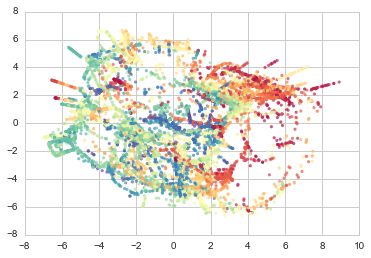

In [248]:
isomap = manifold.Isomap(n_neighbors, n_components)
Y = isomap.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

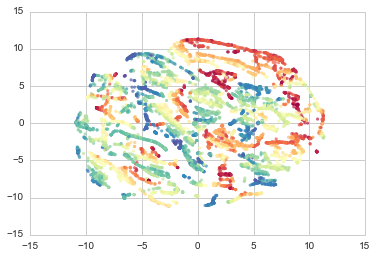

In [249]:
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

In [ ]:
se = manifold.SpectralEmbedding(n_components=n_components, affinity='rbf', n_neighbors=n_neighbors, random_state=0)
Y = se.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=color, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

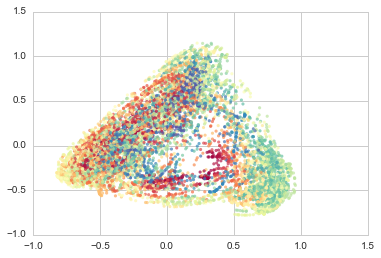

In [252]:
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

In [ ]:
mds = manifold.MDS(n_components, max_iter=100, n_init=1, random_state=0)
Y = mds.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=color, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

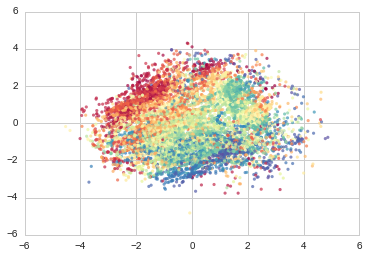

In [254]:
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

# Clustering

In [261]:
colors = np.array([x for x in 'bgrcmybgrcmybgrcmybgrcmy'])
colors = np.hstack([colors] * 40)

def run_clustering(model, **kwargs):
    alg = model(**kwargs)
    alg.fit(X)
    if hasattr(alg, 'labels_'):
        y_pred = alg.labels_.astype(np.int)
    else:
        y_pred = alg.predict(X)
    return y_pred

def plot_clustering(y_pred):
    pylab.figure(figsize=(12,6))
    pylab.subplot(121)
    pylab.title('From Flight Numbers')
    plt.scatter(X[:, 0], X[:, 1], c=YModel, s=10, lw=0, cmap=pylab.cm.jet)
    pylab.subplot(122)
    pylab.title('From Clusters')
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=10, lw=0, cmap=pylab.cm.jet)

(0, 77) 0.911446051951 78 685


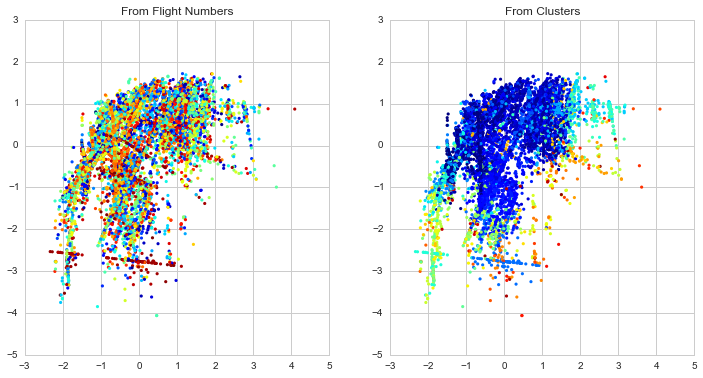

In [262]:
bandwidth = cluster.estimate_bandwidth(X, quantile=0.009)
y_pred = run_clustering(cluster.MeanShift, bandwidth=bandwidth, bin_seeding=True)
plot_clustering(y_pred)
print minmax(y_pred), bandwidth, len(np.unique(y_pred)), len(np.unique(Ymodel))

(-1, 425) 0.911446051951 427 685


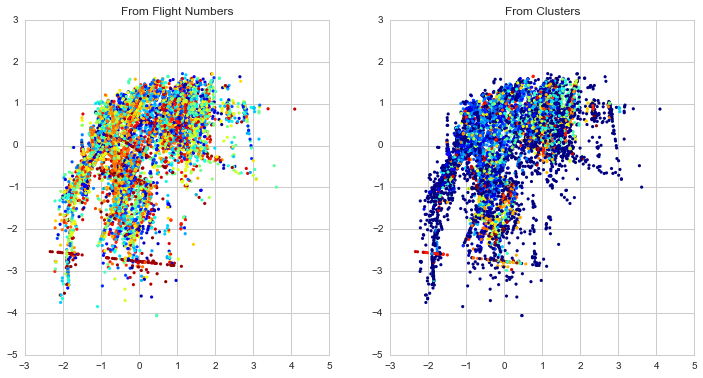

In [263]:
y_pred = run_clustering(cluster.DBSCAN, eps=0.3)
plot_clustering(y_pred)
print minmax(y_pred), bandwidth, len(np.unique(y_pred)), len(np.unique(Ymodel))

In [264]:
from sklearn.neighbors import kneighbors_graph

(0, 684) 0.911446051951 685 685


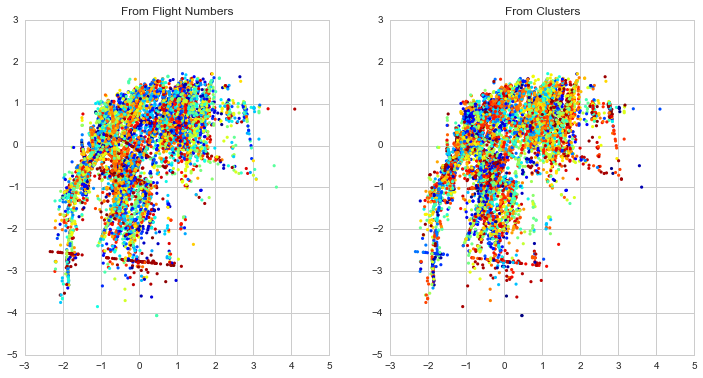

In [265]:
n_clusters = len(np.unique(Ymodel))
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)
y_pred = run_clustering(cluster.AgglomerativeClustering, 
                        n_clusters=n_clusters, linkage='ward',
                        connectivity=connectivity)
plot_clustering(y_pred)
print minmax(y_pred), bandwidth, len(np.unique(y_pred)), len(np.unique(Ymodel))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14072d210>]], dtype=object)

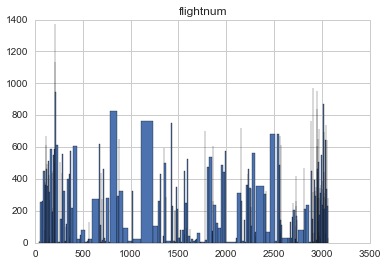

In [319]:
during.hist('flightnum', bins=np.unique(during['flightnum'])-0.5, )

In [5]:
import geoplotlib

In [9]:
# tmp = during.groupby('flightnum', as_index=True).count().sort('x')
tmp = during.groupby(['weekday', 'flightnum'], as_index=True).count().sort('x')
index = tmp.index[-1]
flight = during[during['flightnum'] == index[1]]
# flight.plot('lon', 'lat', 'scatter')
print index, len(flight)

geoplotlib.tiles_provider('darkmatter')
geoplotlib.dot(flight)
bbox = geoplotlib.utils.BoundingBox(40.5,-78.0,38.5,-76)
geoplotlib.set_bbox(bbox)
geoplotlib.inline(800)

(1, 207) 1375


In [46]:
dtime = lambda x: (x - x.shift(1))
tmp = np.array((flight['datenum'] - flight['datenum'].shift()).fillna(0))*24

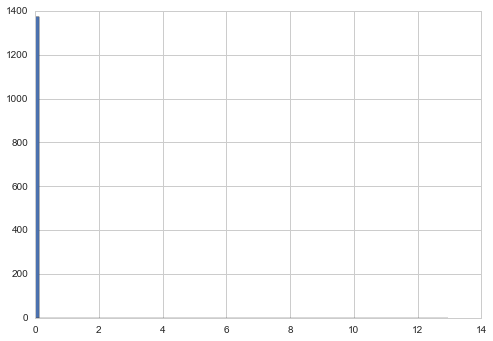

In [47]:
# _ = pylab.hist(np.array(flight['datenum']), 100)
_ = pylab.hist(tmp, 100)

In [45]:
tmp

array([ 0.        ,  0.01508341,  0.07525004, ...,  0.01810005,
        0.06333332,  0.0350833 ])